In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [202]:
kart_data = pd.read_csv("../Data/data.csv",sep=';',decimal=',')

/home/paulo/PycharmProjects/kart-scraping-analysis/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (16,18,19,22,25,28,29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Select only rental races

In [203]:
clean_data = kart_data.loc[kart_data['Classe']=='RENTAL']

In [204]:
def time_spliter(t):
    keys = ['milliseconds','seconds','minutes']
    if isinstance(t, str):
        values = reversed([int(x) for x in re.split("[:.]+", t)])
        time_dict = dict(zip(keys, values))
        return pd.Timedelta(**time_dict)
    else:
        return pd.Timedelta('nat')

In [205]:
columns = ['Melhor Tempo', 'Total Tempo', '2a melhor']
for column in columns:
    clean_data.loc[:,(column)] = clean_data[column].apply(time_spliter)
clean_data = clean_data.loc[clean_data['Melhor Tempo'].notna()]

In [206]:
clean_data.loc[:,('Dia')] = pd.to_datetime(clean_data['Dia'] + '/2019', format='%d/%m/%Y')
clean_data['Week'] = clean_data['Dia'].dt.strftime('%U')
clean_data['Month'] = clean_data['Dia'].dt.strftime('%m')
clean_data.loc[:,('No.')] = clean_data['No.'].apply(lambda x: str(int(x)))

In [207]:
best_lap = clean_data.groupby('uid')['Melhor Tempo'].min()\
                .reset_index().rename({'Melhor Tempo':'Best Circuit Lap'}, axis=1)
clean_data = clean_data.merge(best_lap,how='left',on='uid')
clean_data['Dif from best'] = clean_data['Melhor Tempo'] - clean_data['Best Circuit Lap']

In [218]:
window = ['Month','Week'][1]
group_data = clean_data.groupby([window,'No.'])['Best Circuit Lap'].agg(['sum','count']).reset_index()
group_data['mean'] = group_data['sum']/group_data['count']

In [219]:
filtered = group_data.loc[group_data['count']>1]
filtered

,Week,No.,sum,count,mean
0,17,1,0 days 00:19:32.100000,22,0 days 00:00:53.277272727
1,17,10,0 days 00:24:06.342000,27,0 days 00:00:53.568222222
2,17,11,0 days 00:17:19.250000,18,0 days 00:00:57.736111111
3,17,12,0 days 00:23:19.927000,26,0 days 00:00:53.843346153
4,17,13,0 days 00:25:39.814000,28,0 days 00:00:54.993357142
...,...,...,...,...,...
2600,52,55,0 days 00:02:47.823000,3,0 days 00:00:55.941000
2601,52,6,0 days 00:08:36.410000,9,0 days 00:00:57.378888888
2602,52,7,0 days 00:13:39.971000,14,0 days 00:00:58.569357142
2603,52,8,0 days 00:13:29.989000,14,0 days 00:00:57.856357142


In [220]:
cars_list = [str(n) for n in range(1,99)]
_df = filtered.loc[filtered['No.'].isin(cars_list),(window,'No.','mean')]\
            .pivot(index=window,columns=['No.'],values=['mean'])['mean']
_mean = _df.mean(axis=1)
for column in _df:
    _df[column] = _df[column] - _mean

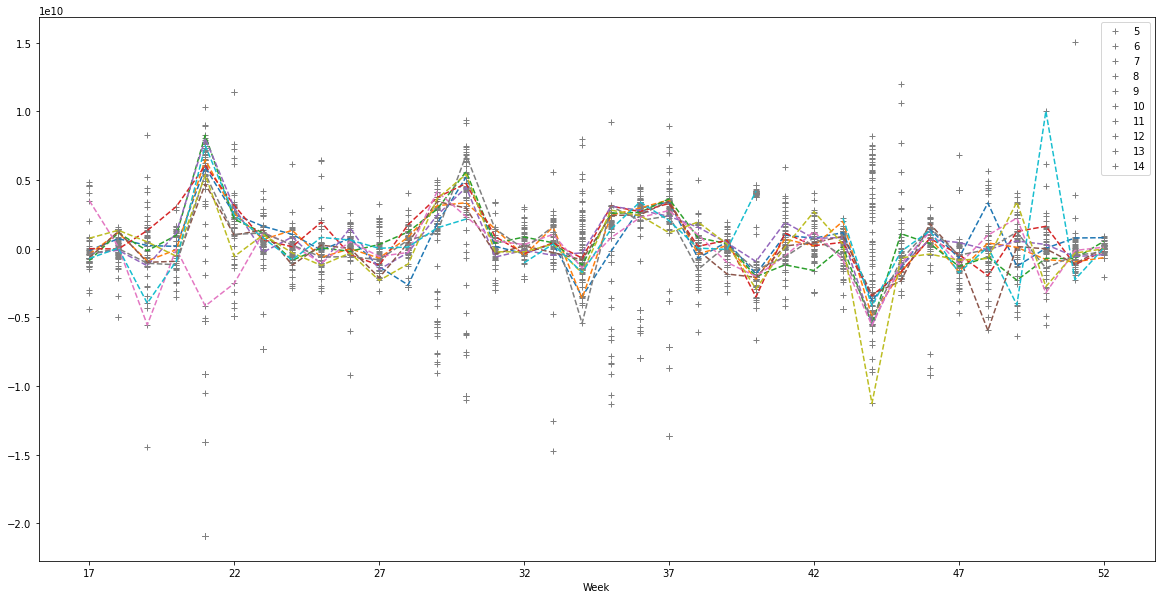

In [229]:
_df.plot(figsize=(20, 10), style='+',legend=False,color='grey')
for i in range(5,15):
    _df[str(i)].plot(style='--',legend=True)